# Graphs and Charts are shown throughout if you would like to skip the code

In [1]:
import os
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
import warnings
pd.options.display.max_columns=21
warnings.filterwarnings("ignore")

In [2]:
approved_statuses = ['Approved',
                     'Contracts Back',
                     'Contract Sent',
                     'Soft Approval',
                     'Ready to Fund',
                     'Lost Deal',
                     'Contract Returned',
                     'Funding Call',
                     'Open Approval']
declined_statuses = ['Negative Balances',
                     'Declined',
                     'Bad Credit',
                     'Too Small',
                     'No Room',
                     'Previous Default',
                     'Merchant Declined',
                     'Declined Previously',
                     'Too Few Deposits',
                     'SIC Code',
                     'Declined Bad Iso',
                     'Suspected Fraud',
                     'Auto-declined',
                     'Fraud',
                     'Missing Stips',
                     'Merchant Declined',
                     'No Logins',
                     'No COJ',
                     'Negative Banks',
                     'New MCA',
                     'Poor Landlord',
                     'Contracts Back Declined']
funded_statuses = ['Funded']

In [3]:
def status_groups(g):
    if g in approved_statuses:
        return "approved"
    elif g in declined_statuses:
        return "declined"
    elif g in funded_statuses:
        return "funded"
    else:
        return "still in submission"

## Need to import and clean the data

In [4]:
df = pd.read_excel("business_capital_deals.xlsx",
                   parse_dates=True,
                   usecols="A:G,K")
df = df.set_index(df.created_at)
df['group_status'] = df['status'].apply(status_groups)
df.loc[(df["group_status"].isin(["still in submission","declined"])) & (df["funded_amount"]!=0),"funded_amount"] = 0
df.loc[(df["funded_amount"]>0) & (df["funded_amount"]<3000), "funded_amount"].apply(lambda x: x*1000)



month_counts = df.groupby([pd.Grouper(freq="M"), "group_status"])["funded_amount"].agg(["count","sum","mean"])
month_counts["pct_of_total_submissions"] = df.groupby([pd.Grouper(freq="M"), "group_status"])["funded_amount"].agg(["count"]).groupby(level=0).apply(lambda x: x/float(x.sum()))
month_counts = month_counts.unstack()
for x in month_counts["count"].columns:
    if x != "still in submission":
        month_counts["count " + str(x) + " pct_ch"] = month_counts["count"][x].pct_change()
for x in month_counts["sum"].columns:
    if x != "still in submission":
        month_counts["sum " + str(x) + " pct_ch"] = month_counts["sum"][x].pct_change()
month_groups = df.groupby([pd.Grouper(freq='M')])["funded_amount"].agg(["count","sum"])
month_groups["Mean Approved Amount"] = df[(df["group_status"].isin(["approved","funded"]) & (df["funded_amount"]>=3000))]["funded_amount"].groupby([pd.Grouper(freq='M')]).agg("mean")
month_groups["count_pct_ch"] = df.groupby(pd.Grouper(freq="M"))["id"].count().pct_change()
month_groups["sum_pct_ch"] = df.groupby(pd.Grouper(freq="M"))["funded_amount"].sum().pct_change()
month_groups.columns = ["Total Submissions","Total Approved and Funded","Mean Approved Amount","Total Submissions Percent Change","Total Approved and Funded Percent Change"]
combined_df = pd.concat([month_counts,month_groups],axis=1)
combined_df.columns = ["Approved Count",
                   "Declined Count",
                   "Funded Count",
                   "Still in Submission Count",
                   "Sum of Open Approvals",
                   "Sum of Declined Approvals (drop)",
                   "Sum of Funded Deals",
                   "Sum of Still in Submission Deals (drop)",
                   "Average Approval (drop)",
                   "Average Declined (drop)",
                   "Average Funded Amount",
                   "Average Submission (drop)",
                   "Approved Percent of Total Submissions",
                   "Declined Percent of Total Submissions",
                   "Funded Percent of Total Submissions",
                   "Still in Submission Percent of Total Submissions",
                   'Total Approved Percent Change',
                   'Total Declined Percent Change',
                   'Total Funded Percent Change',
                   'Sum Open Approvals Percent Change',
                   'Sum Declined Percent Change (drop)',
                   'Sum Funded Percent Change',
                   'Total Submissions',
                   'Total Approved and Funded',
                   'Average Approval Amount',
                   'Total Submissions Percent Change',
                   'Total Approved and Funded Percent Change']
for z in combined_df.columns:
    if "(drop)" in z:
        combined_df = combined_df.drop(z,axis=1)
cols = combined_df.columns.tolist()
cols = [cols[16], # 16 Total Submissions
        cols[19], # 19 Total Submissions Percent Change
        cols[17], # 17 Total Approved and Funded
        cols[20], # 20 Total Approved and Funded Percent Change
        cols[5],  # 5  Sum of Funded Deals
        cols[6],  # 6  Average Funded Amount
        cols[15], # 15 Sum Funded Percent Change
        cols[4],  # 4  Sum of Open Approvals
        cols[18], # 18 Average Approval Amount
        cols[14], # 14 Sum Open Approvals Percent Change
        cols[3],  # 3  Still in Submission Count
        cols[10], # 10 Still in Submission Percent of Total Submissions
        cols[0],  # 0  Approved Count
        cols[11], # 11 Total Approved Percent Change
        cols[7],  # 7  Approved Percent of Total Submissions
        cols[2],  # 2  Funded Count
        cols[13], # 13 Total Funded Percent Change
        cols[9],  # 9  Funded Percent of Total Submissions
        cols[1],  # 1  Declined Count
        cols[12], # 12 Total Declined Percent Change
        cols[8]]  # 8  Declined Percent of Total Submissions

combined_df = combined_df[cols]

stacked_uw_group_status_breakdown = df.groupby(['underwriter','group_status'])['id'].count().unstack(fill_value=0).T
stacked_uw_status_breakdown = df.groupby(['underwriter','status'])['id'].count().unstack(fill_value=0).T

def group_uw_by_status(df):
    df["Total"] = [df.T[x].sum() for x in df.T.columns]
    df = df.T
    df["Total"] = [df.T[x].sum() for x in df.T.columns]
    return df

## Here are our metrics grouped by month:
### You can view the metrics provided below.

In [5]:
# writer = pd.ExcelWriter(str(filename) + " ISO_Report.xlsx", engine="xlsxwriter")
pd.DataFrame(np.array(combined_df.columns.to_list()).reshape((3,7)))

,0,1,2,3,4,5,6
0,Total Submissions,Total Submissions Percent Change,Total Approved and Funded,Total Approved and Funded Percent Change,Sum of Funded Deals,Average Funded Amount,Sum Funded Percent Change
1,Sum of Open Approvals,Average Approval Amount,Sum Open Approvals Percent Change,Still in Submission Count,Still in Submission Percent of Total Submissions,Approved Count,Total Approved Percent Change
2,Approved Percent of Total Submissions,Funded Count,Total Funded Percent Change,Funded Percent of Total Submissions,Declined Count,Total Declined Percent Change,Declined Percent of Total Submissions


In [6]:
combined_df #.to_excel(writer, sheet_name="Report")

,Total Submissions,Total Submissions Percent Change,Total Approved and Funded,Total Approved and Funded Percent Change,Sum of Funded Deals,Average Funded Amount,Sum Funded Percent Change,Sum of Open Approvals,Average Approval Amount,Sum Open Approvals Percent Change,Still in Submission Count,Still in Submission Percent of Total Submissions,Approved Count,Total Approved Percent Change,Approved Percent of Total Submissions,Funded Count,Total Funded Percent Change,Funded Percent of Total Submissions,Declined Count,Total Declined Percent Change,Declined Percent of Total Submissions
created_at,,,,,,,,,,,,,,,,,,,,,
2019-01-31,223,NaN,9278500,NaN,3825000,78061.224490,NaN,5453500,94678.571429,NaN,17,0.076233,87,NaN,0.390135,49,NaN,0.219731,70,NaN,0.313901
2019-02-28,168,-0.246637,9204250,-0.008002,4441750,108335.365854,0.161242,4762500,116509.493671,-0.126708,11,0.065476,62,-0.287356,0.369048,41,-0.163265,0.244048,54,-0.228571,0.321429
2019-03-31,132,-0.214286,6527041,-0.290867,3181041,67681.723404,-0.283832,3346000,88203.256757,-0.297428,15,0.113636,41,-0.338710,0.310606,47,0.146341,0.356061,29,-0.462963,0.219697
2019-04-30,132,0.000000,6721000,0.029716,4250000,106250.000000,0.336041,2471000,90824.324324,-0.261506,15,0.113636,49,0.195122,0.371212,40,-0.148936,0.303030,28,-0.034483,0.212121
2019-05-31,161,0.219697,9466578,0.408507,6065578,129054.851064,0.427195,3401000,105184.200000,0.376366,26,0.161491,56,0.142857,0.347826,47,0.175000,0.291925,32,0.142857,0.198758
2019-06-30,160,-0.006211,6635500,-0.299060,4945500,86763.157895,-0.184661,1690000,78994.047619,-0.503087,23,0.143750,56,0.000000,0.350000,57,0.212766,0.356250,24,-0.250000,0.150000
2019-07-31,192,0.200000,9559000,0.440585,6211000,108964.912281,0.255889,3348000,105043.956044,0.981065,23,0.119792,58,0.035714,0.302083,57,0.000000,0.296875,54,1.250000,0.281250
2019-08-31,188,-0.020833,8403500,-0.120881,5887000,133795.454545,-0.052166,2516500,112046.666667,-0.248357,20,0.106383,71,0.224138,0.377660,44,-0.228070,0.234043,53,-0.018519,0.281915
2019-09-30,185,-0.015957,6611900,-0.213197,4316000,113578.947368,-0.266859,2295900,88158.666667,-0.087661,17,0.091892,77,0.084507,0.416216,38,-0.136364,0.205405,53,0.000000,0.286486


## The dataset is grouped by underwriter and statuses below:

In [7]:
group_uw_by_status(stacked_uw_status_breakdown)#.to_excel(writer, sheet_name="UW_Status_Report")

status,Approved,Bad Credit,Contract Returned,Contract Sent,Contracts Back Declined,Declined,Declined Previously,Funded,Lost Deal,Need Info / Stmts,Negative Balances,Negative Banks,New,No Room,Open Approval,Previous Default,SIC Code,Soft Approval,Too Few Deposits,Too Small,Total
underwriter,,,,,,,,,,,,,,,,,,,,,
Allen fisher,1,3,0,0,0,0,1,22,0,2,0,0,0,3,49,4,0,0,2,4,91
Bryan Miller,0,0,0,0,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,3
Dave sneiderman,45,43,1,1,7,81,5,103,1,36,65,1,1,99,337,19,11,2,0,51,909
David New,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
Henry p,0,0,0,4,0,0,0,24,0,0,0,0,1,0,14,0,0,0,0,0,43
Joe rapoport,3,1,0,1,0,1,0,54,0,1,0,0,13,6,39,2,0,0,0,1,122
Jp high risk,0,0,0,62,0,2,1,223,0,0,0,0,121,3,9,1,0,0,0,0,422
Madeline,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
Mendy hecht,2,3,0,0,0,6,0,15,0,4,0,0,9,4,22,0,0,15,0,0,80


## The dataset is grouped by underwriter and status group below:

In [8]:
group_uw_by_status(stacked_uw_group_status_breakdown)#.to_excel(writer, sheet_name="UW_Group_Status_Report")
# writer.save()

group_status,approved,declined,funded,still in submission,Total
underwriter,,,,,
Allen fisher,50,17,22,2,91
Bryan Miller,0,0,1,2,3
Dave sneiderman,387,382,103,37,909
David New,0,0,1,0,1
Henry p,18,0,24,1,43
Joe rapoport,43,11,54,14,122
Jp high risk,71,7,223,121,422
Madeline,0,0,1,0,1
Mendy hecht,39,13,15,13,80


<Figure size 432x288 with 0 Axes>

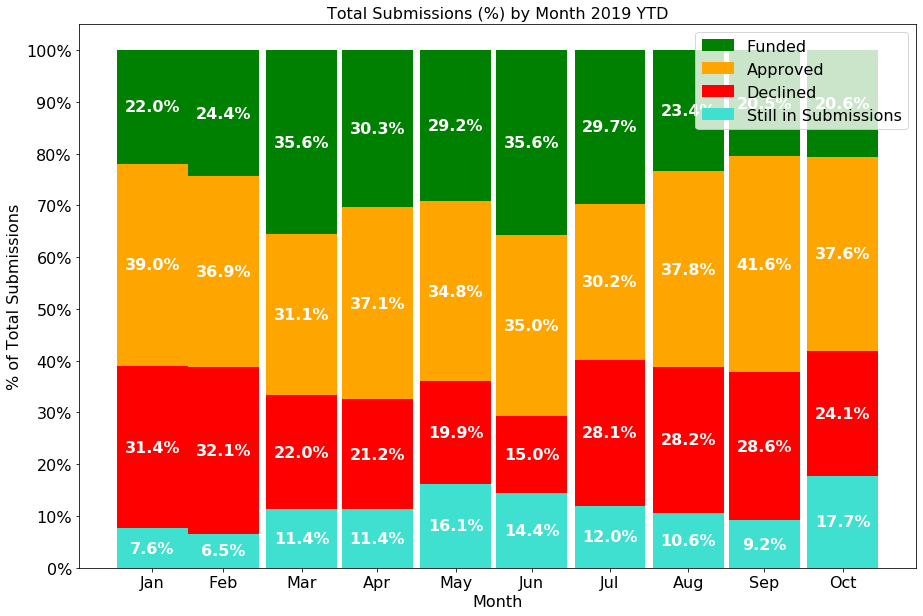

In [9]:
plt.clf()
plt.figure(figsize=(15,10))
# ax = fig.add_subplot(111)

p1 = plt.bar(combined_df.index, combined_df["Still in Submission Percent of Total Submissions"],color="turquoise", width=1, align='center')
p2 = plt.bar(combined_df.index, combined_df["Declined Percent of Total Submissions"],bottom=combined_df["Still in Submission Percent of Total Submissions"], color="red", width=1, align='center')
p3 = plt.bar(combined_df.index, combined_df["Approved Percent of Total Submissions"], bottom=combined_df["Still in Submission Percent of Total Submissions"] + combined_df["Declined Percent of Total Submissions"], color="orange", width=1, align='center')
p4 = plt.bar(combined_df.index, combined_df["Funded Percent of Total Submissions"],bottom=combined_df["Still in Submission Percent of Total Submissions"] + combined_df["Declined Percent of Total Submissions"] + combined_df["Approved Percent of Total Submissions"], color="green", width=1, align='center')

plt.ylabel("% of Total Submissions", fontsize=16)
plt.xlabel("Month", fontsize=16)
plt.title("Total Submissions (%) by Month 2019 YTD", fontsize=16)
plt.xticks(combined_df.index, combined_df.index.strftime("%b"), fontsize=16)
plt.yticks(np.arange(0,11)/10,["{:.0%}".format(x) for x in np.arange(0,11)/10], fontsize=16)
plt.legend((p4[0],p3[0],p2[0],p1[0]), ("Funded","Approved","Declined","Still in Submissions"), fontsize=16)

for r1, r2, r3, r4 in zip(p1,p2,p3,p4):
    h1,h2,h3,h4 = r1.get_height(), r2.get_height(), r3.get_height(), r4.get_height()
    plt.text(r1.get_x() + r1.get_width() / 2., h1 / 2., "{:.1%}".format(h1), ha="center", va="center", color="white", fontsize=16, fontweight="bold")
    plt.text(r2.get_x() + r2.get_width() / 2., h1+h2 / 2., "{:.1%}".format(h2), ha="center", va="center", color="white", fontsize=16, fontweight="bold")
    plt.text(r3.get_x() + r3.get_width() / 2., h1+h2+h3 / 2., "{:.1%}".format(h3), ha="center", va="center", color="white", fontsize=16, fontweight="bold")
    plt.text(r4.get_x() + r4.get_width() / 2., h1+h2+h3+h4 / 2., "{:.1%}".format(h4), ha="center", va="center", color="white", fontsize=16, fontweight="bold")
plt.show()
# plt.savefig('total_submissions_by_month.jpeg')
# print("Image File Generated: total_submissions_by_month.jpeg")

<Figure size 432x288 with 0 Axes>

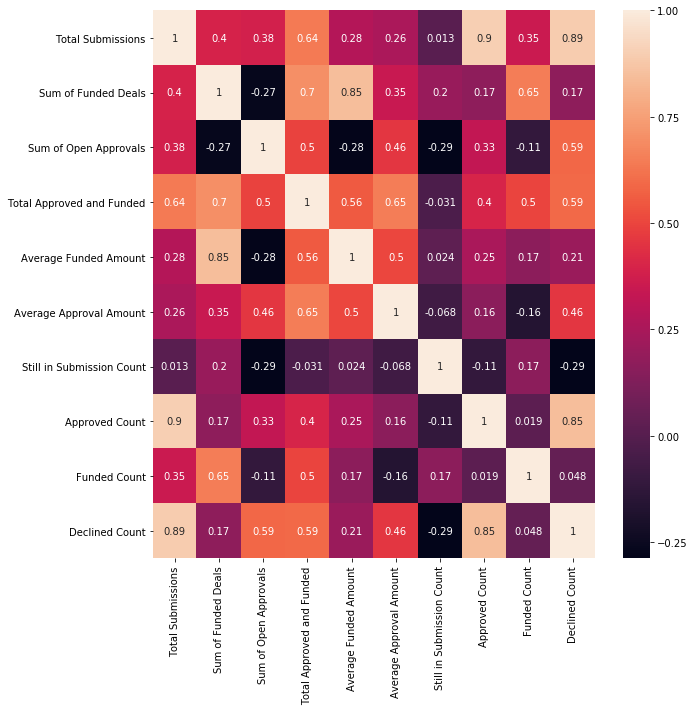

In [10]:
plt.clf()
correlation_data = combined_df.iloc[:,[0,4,7,2,5,8,10,12,15,18]]
corr = correlation_data.corr()
fig, ax = plt.subplots(figsize=(10,10))         # Sample figsize in inches

fig = sns.heatmap(corr, annot=True, ax=ax)
plt.tight_layout()
ax.set_ylim(bottom=10, top=0)
plt.show()
# plt.savefig("correlation_plot.jpeg")
# print("Image File Generated: correlation_plot.jpeg")

<Figure size 432x288 with 0 Axes>

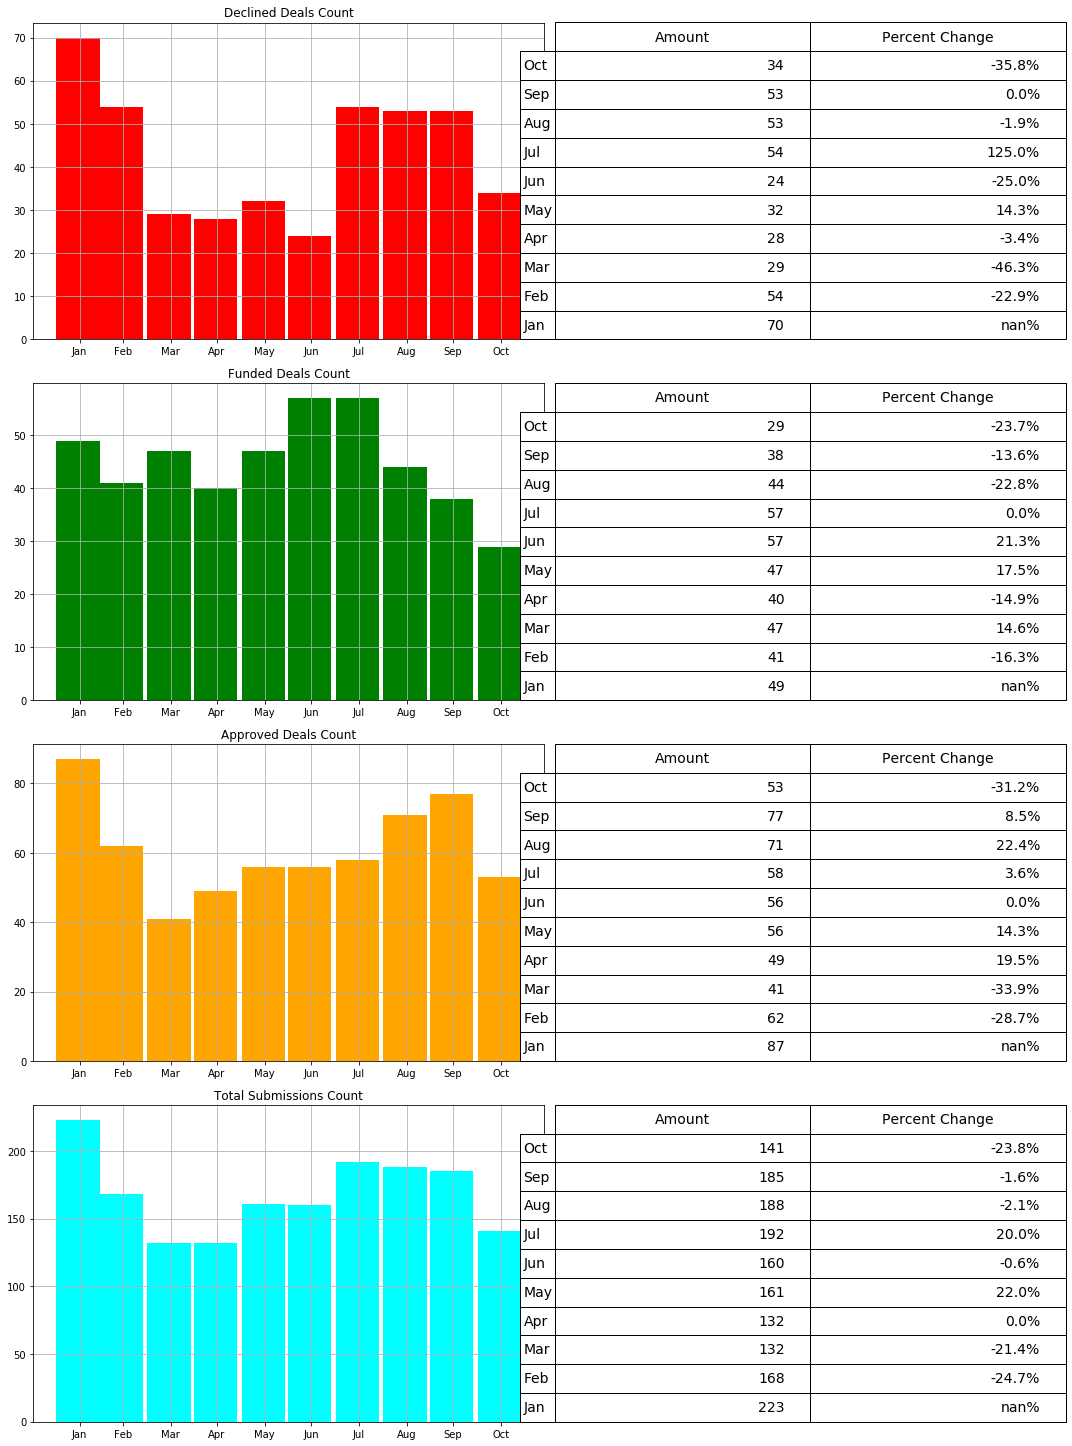

In [11]:
plt.clf()
fig = plt.figure(figsize=(15,40))

ax1 = fig.add_subplot(821)
ax1.bar(combined_df.index, combined_df["Declined Count"],color="red", width=1, align='center')
ax1.set_xticklabels(combined_df.index.strftime("%b"))
ax1.grid(True)
ax1.autoscale(axis="y")
ax1.set_yticklabels(['{:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
ax1.set_title("Declined Deals Count")

cell_text = ['{:,}'.format(x) for x in combined_df["Declined Count"]]
table_labels = [combined_df.index[x].strftime("%b") for x in range(len(combined_df.index))][::-1]
cell_pct_ch = ["{:.1%}".format(x) for x in combined_df["Total Declined Percent Change"]]
declined_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

ax2 = fig.add_subplot(822)
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = declined_df.values,
                      rowLabels = declined_df.index,
                      bbox=bbox,
                      colLabels=declined_df.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

ax3 = fig.add_subplot(823)
ax3.bar(combined_df.index, combined_df["Funded Count"],color="green", width=1, align='center')
ax3.set_xticklabels(combined_df.index.strftime("%b"))
ax3.grid(True)
ax3.autoscale(axis="y")
ax3.set_yticklabels(['{:,}'.format(int(x)) for x in ax3.get_yticks().tolist()])
ax3.set_title("Funded Deals Count")

cell_text = ['{:,}'.format(x) for x in combined_df["Funded Count"]]
table_labels = [combined_df.index[x].strftime("%b") for x in range(len(combined_df.index))][::-1]
cell_pct_ch = ["{:.1%}".format(x) for x in combined_df["Total Funded Percent Change"]]
funded_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

ax3 = fig.add_subplot(824)
font_size=14
bbox=[0, 0, 1, 1]
ax3.axis('off')
mpl_table = ax3.table(cellText = funded_df.values,
                      rowLabels = funded_df.index,
                      bbox=bbox,
                      colLabels=funded_df.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

ax4 = fig.add_subplot(825)
ax4.bar(combined_df.index, combined_df["Approved Count"],color="orange", width=1, align='center')
ax4.set_xticklabels(combined_df.index.strftime("%b"))
ax4.grid(True)
ax4.autoscale(axis="y")
ax4.set_yticklabels(['{:,}'.format(int(x)) for x in ax4.get_yticks().tolist()])
ax4.set_title("Approved Deals Count")

cell_text = ['{:,}'.format(x) for x in combined_df["Approved Count"]]
table_labels = [combined_df.index[x].strftime("%b") for x in range(len(combined_df.index))][::-1]
cell_pct_ch = ["{:.1%}".format(x) for x in combined_df["Total Approved Percent Change"]]
approved_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

ax4 = fig.add_subplot(826)
font_size=14
bbox=[0, 0, 1, 1]
ax4.axis('off')
mpl_table = ax4.table(cellText = approved_df.values,
                      rowLabels = approved_df.index,
                      bbox=bbox,
                      colLabels=approved_df.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)


ax5 = fig.add_subplot(827)
ax5.bar(combined_df.index, combined_df["Total Submissions"],color="cyan", width=1, align='center')
ax5.set_xticklabels(combined_df.index.strftime("%b"))
ax5.grid(True)
ax5.autoscale(axis="y")
ax5.set_yticklabels(['{:,}'.format(int(x)) for x in ax5.get_yticks().tolist()])
ax5.set_title("Total Submissions Count")

cell_text = ['{:,}'.format(x) for x in combined_df["Total Submissions"]]
table_labels = [combined_df.index[x].strftime("%b") for x in range(len(combined_df.index))][::-1]
cell_pct_ch = ["{:.1%}".format(x) for x in combined_df["Total Submissions Percent Change"]]
submissions_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

ax5 = fig.add_subplot(828)
font_size=14
bbox=[0, 0, 1, 1]
ax5.axis('off')
mpl_table = ax5.table(cellText = submissions_df.values,
                      rowLabels = submissions_df.index,
                      bbox=bbox,
                      colLabels=submissions_df.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
plt.tight_layout()
plt.show()
# plt.savefig('counts_and_amounts.jpeg')
# print("Image File Generated: counts_and_amounts.jpeg")

<Figure size 432x288 with 0 Axes>

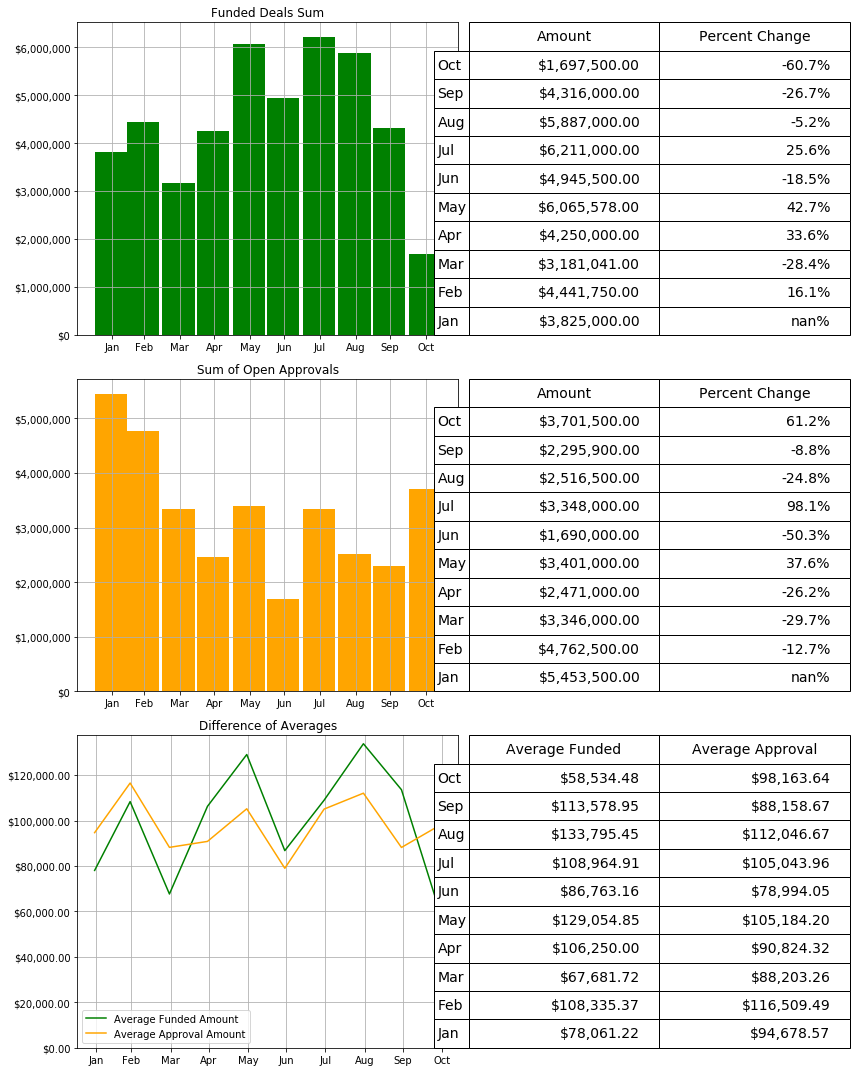

In [12]:
plt.clf()
fig = plt.figure(figsize=(12,15))

ax1 = fig.add_subplot(323)
ax1.bar(combined_df.index, combined_df["Sum of Open Approvals"],color="orange", width=1, align='center')
ax1.set_xticklabels(combined_df.index.strftime("%b"))
ax1.grid(True)
ax1.autoscale(axis="y")
ax1.set_yticklabels(['${:,}'.format(np.int(x)) for x in ax1.get_yticks().tolist()])
ax1.set_title("Sum of Open Approvals")

cell_text = ['${:,.2f}'.format(x) for x in combined_df["Sum of Open Approvals"]]
table_labels = [combined_df.index[x].strftime("%b") for x in range(len(combined_df.index))][::-1]
cell_pct_ch = ["{:.1%}".format(x) for x in combined_df["Sum Open Approvals Percent Change"]]
open_approvals_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

ax2 = fig.add_subplot(324)
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = open_approvals_df.values,
                      rowLabels = open_approvals_df.index,
                      bbox=bbox,
                      colLabels=open_approvals_df.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
# plt.savefig("Sum_of_Open_Approvals.jpeg")

# Sum of Funded Deals
# Sum Funded Percent Change

ax3 = fig.add_subplot(321)
ax3.bar(combined_df.index,combined_df["Sum of Funded Deals"],color="green", width=1, align='center')
ax3.set_xticklabels(combined_df.index.strftime("%b"))
ax3.grid(True)
ax3.autoscale(axis="y")
ax3.set_yticklabels(['${:,}'.format(int(x)) for x in ax3.get_yticks().tolist()])
ax3.set_title("Funded Deals Sum")

cell_text = ['${:,.2f}'.format(x) for x in combined_df["Sum of Funded Deals"]]
table_labels = [combined_df.index[x].strftime("%b") for x in range(len(combined_df.index))][::-1]
cell_pct_ch = ["{:.1%}".format(x) for x in combined_df["Sum Funded Percent Change"]]
funded_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

ax3 = fig.add_subplot(322)
font_size=14
bbox=[0, 0, 1, 1]
ax3.axis('off')
mpl_table = ax3.table(cellText = funded_df.values,
                      rowLabels = funded_df.index,
                      bbox=bbox,
                      colLabels=funded_df.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)

ax4 = fig.add_subplot(325)
ax4.plot(combined_df["Average Funded Amount"], label="Average Funded Amount", color="green")
ax4.plot(combined_df["Average Approval Amount"], label="Average Approval Amount", color="orange")
ax4.set_xticklabels(combined_df.index.strftime("%b"))
ax4.legend(["Average Funded Amount","Average Approval Amount"],loc='lower left')
ax4.grid(True)
ax4.autoscale(axis="y")
ax4.set_ybound(lower=0)
ax4.set_yticklabels(['${:,.2f}'.format(np.int(x)) for x in ax4.get_yticks()])


ax4.set_title("Difference of Averages")

cell_text = ['${:,.2f}'.format(x) for x in combined_df["Average Funded Amount"]]
table_labels = [combined_df.index[x].strftime("%b") for x in range(len(combined_df.index))][::-1]
cell_pct_ch = ["${:,.2f}".format(x) for x in combined_df["Average Approval Amount"]]
average_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Average Funded","Average Approval"), index=table_labels)

ax4 = fig.add_subplot(326)
font_size=14
bbox=[0, 0, 1, 1]
ax4.axis('off')
mpl_table = ax4.table(cellText = average_df.values,
                      rowLabels = average_df.index,
                      bbox=bbox,
                      colLabels=average_df.columns,
                      colWidths=[1,1])
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
plt.tight_layout()
plt.show()
# plt.savefig("approved_and_funded_amount_trends.jpeg")
# print("Image File Generated: approved_and_funded_amount_trends.jpeg")

<Figure size 432x288 with 0 Axes>

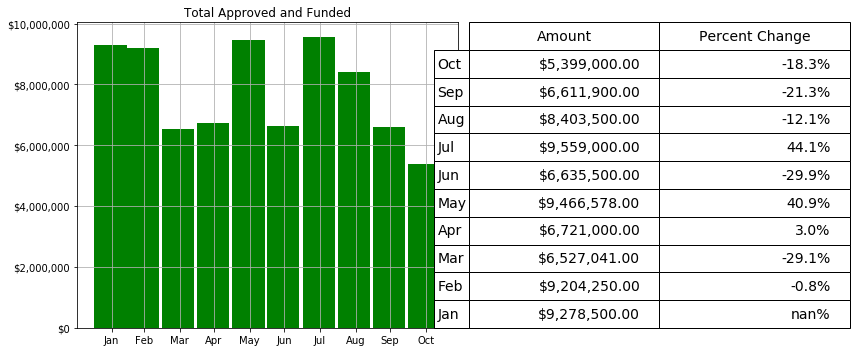

In [13]:
plt.clf()
fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(121)
ax1.bar(combined_df.index, combined_df["Total Approved and Funded"],color="green", width=1, align='center')
ax1.set_xticklabels(combined_df.index.strftime("%b"))
ax1.grid(True)
ax1.autoscale(axis="y")
ax1.set_yticklabels(['${:,}'.format(int(x)) for x in ax1.get_yticks().tolist()])
ax1.set_title("Total Approved and Funded")

cell_text = ['${:,.2f}'.format(x) for x in combined_df["Total Approved and Funded"]]
table_labels = [combined_df.index[x].strftime("%b") for x in range(len(combined_df.index))][::-1]
cell_pct_ch = ["{:.1%}".format(x) for x in combined_df["Total Approved and Funded Percent Change"]]
funded_and_approved_df = pd.DataFrame(zip(cell_text[::-1],cell_pct_ch[::-1]), columns=("Amount","Percent Change"), index=table_labels)

ax2 = fig.add_subplot(122)
font_size=14
bbox=[0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText = funded_and_approved_df.values,
                      rowLabels = funded_and_approved_df.index,
                      bbox=bbox,
                      colLabels=funded_and_approved_df.columns)
mpl_table.auto_set_font_size(False)
mpl_table.set_fontsize(font_size)
plt.tight_layout()
plt.show()
# plt.savefig("Total_Approved_and_Funded.jpeg")
# print("Image File Generated: Total_Approved_and_Funded.jpeg")

<Figure size 432x288 with 0 Axes>

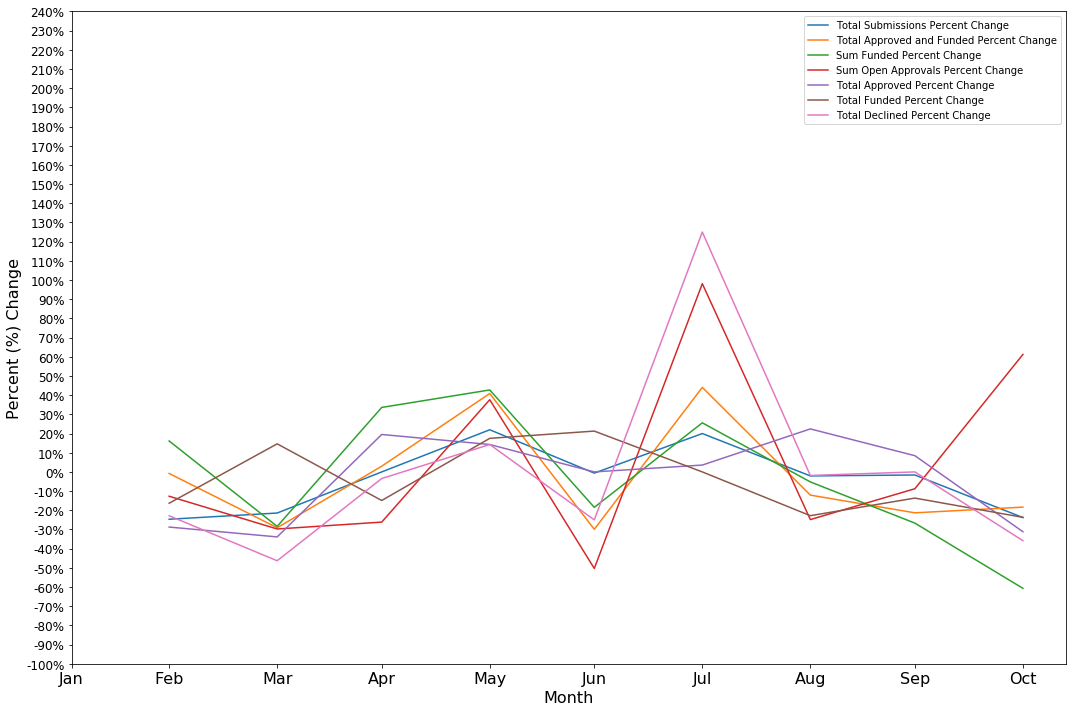

In [14]:
plt.clf()
plt.figure(figsize=(15,10))

for x in combined_df.columns:
    if "Percent Change" in x:
        plt.plot(combined_df[x], label=x)

plt.xticks(combined_df.index, combined_df.index.strftime("%b"), fontsize=16)
plt.yticks(np.arange(-10,25)/10,["{:.0%}".format(x) for x in np.arange(-10,25)/10], fontsize=12)
plt.xlabel("Month", fontsize=16)
plt.ylabel("Percent (%) Change", fontsize=16)
plt.legend()
plt.tight_layout()
plt.show()
# plt.savefig("percent_changes.jpeg")
# print("Image File Generated: percent_changes.jpeg")

In [15]:
def main():
    for filename in os.listdir("./"):
        if filename.endswith(".xlsx"):
            df_maker(filename)
            print("Report File Generated: " + filename[:-5] + " ISO_Report.xlsx")
            stacked_bar_chart(df_maker(filename))
            corr_plot(df_maker(filename))
            counts_and_amounts(df_maker(filename))
            approved_and_funded_amount_trends(df_maker(filename))
            total_approved_and_funded(df_maker(filename))
            percent_changes(df_maker(filename))
            print("Finished with: ",filename[:-5])
